In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.columns

Index(['2000900', '2000901', '2000903', '2000904', '2000905', '2000906',
       '2000907', '2000908', '2000909', '2000910',
       ...
       '2001188', '2001189', '2001190', '2001192', '2001193', '2001194',
       '2001195', '2001197', '2001199', 'pv_1kw'],
      dtype='object', length=174)

# Set study on 20 households

In [3]:
nb_houses = 20

In [4]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

Average consumption is 5.56 MWh


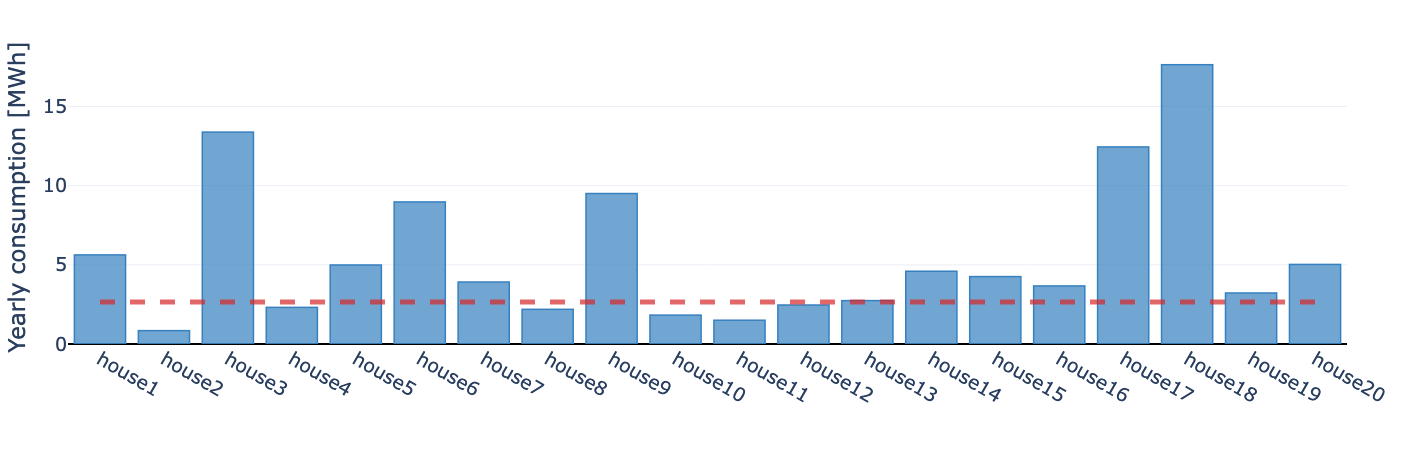

In [5]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house20",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    width=900,
    autosize=False,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [6]:
_individuals = df.copy()
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

In [7]:
individuals = _individuals.copy()

# Fix variables
deltat = timedelta(minutes=15)
training = timedelta(days=31) - timedelta(days=1)  # 1 day for lagged varaibles

# Where do we forecast?
start = datetime(2019, 5, 30, 6, 0, 0)
full_horizon = timedelta(days=7)

# To truncate data
end = start + full_horizon + timedelta(days=2)  # 1 day to keep optimizing at 11pm last day

pv_size = 3
individuals = individuals.loc[start-training:end, :].copy()
for col in individuals.columns:
    individuals[col] -= pv_size * individuals["pv_1kw"]
individuals.drop(columns=["pv_1kw"], inplace=True)

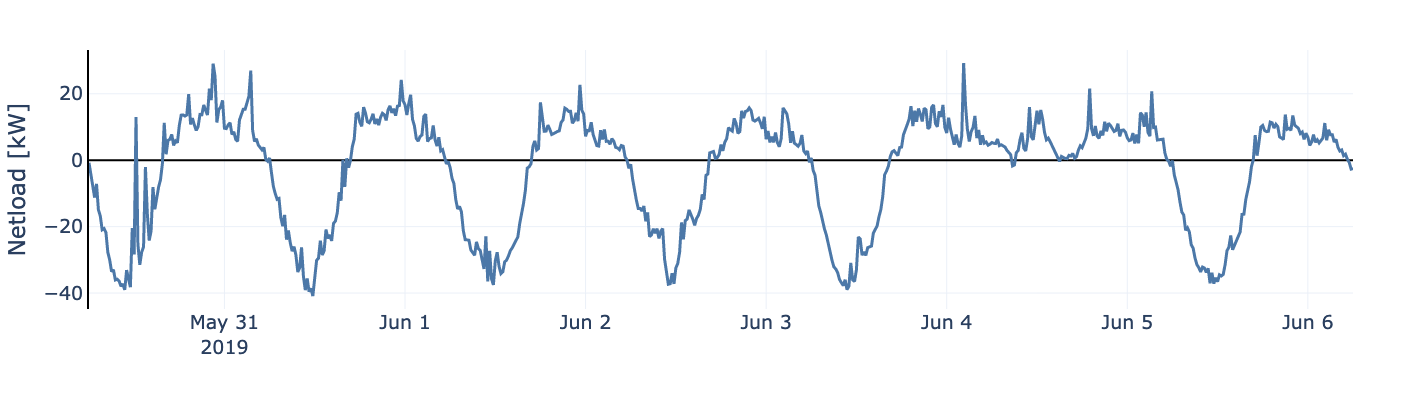

In [8]:
graph = individuals.loc[start:start+full_horizon, :].sum(axis=1).copy()

fig = px.line(graph)
fig.data[0].update(line_width=3)
fig.update_layout(
    layout,
    height=400,
    width=800,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

# Forecast at different freq (test 1 house)

In [9]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm.notebook import tqdm

class GAM():
    """Generalized Additive Model.
    """

    def __init__(self, output, regressors=None, 
                 daily_seasonality="auto",
                 seasonality_prior_scale=10.0):
        
        self._output = output
        self._model = Prophet(
            growth='flat',
            yearly_seasonality=False,
            weekly_seasonality="auto",
            daily_seasonality=daily_seasonality,
            seasonality_mode="additive",
            interval_width=0.95,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=seasonality_prior_scale,
            uncertainty_samples=False,
        )
        if regressors is None:
            regressors = list()
        for reg in regressors:
            self._model.add_regressor(
                name=reg["name"], 
                prior_scale=reg["prior_scale"])

    def fit(self, df):
        with suppress_stdout_stderr():
            self._model.fit(self._specific_formatting(df))

    def predict(self, df):
        forecast = self._model.predict(self._specific_formatting(df))
        forecast.set_index("ds", inplace=True, drop=True)
        forecast.drop(columns=forecast.columns.difference(["yhat"]), inplace=True)
        forecast.rename(columns={"yhat": self._output}, inplace=True)
        return forecast

    def _specific_formatting(self, df):
        df = df.copy()
        df["ds"] = df.index.tz_localize(None)
        df.rename(columns={self._output: "y"}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df


class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


def get_gof(df, result, ref_col, pred_col):
    """
    gof = (1 - NRMSE) * 100
    """
    pred = result.loc[:, [pred_col]].copy()
    if pred.index.tzinfo is None:
        pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], [ref_col]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2) 
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

def lag_values(df, nb_lag, output_col):
    tmp = df.copy()
    for shift in nb_lag:
        tmp[f"t-{shift}"] = tmp[output_col].shift(shift)
    return tmp

def predict_n_periods_with_autoreg(df, start_training, end_training, horizon,
                                   deltat, end_complete_pred, freq, output_col,
                                   regressors, nb_lag, seasonality_prior_scale=1.0,
                                   disable_progress_bar=False, daily_seasonality="auto"):
    """
    Train a GAM and predict for horizon T
    Shift prediction start and predict over T again.
    
    results : [pd.DataFrame] One frame per prediction.
    """
    
    inputs = [reg["name"] for reg in regressors]
    results = []
    model = GAM(output_col, regressors, daily_seasonality=daily_seasonality,
                seasonality_prior_scale=seasonality_prior_scale)
    
    tmp = lag_values(df.loc[start_training-timedelta(days=1):end_training], nb_lag, output_col)
    model.fit(tmp.loc[start_training:end_training])
    
    # Number of forecast where we have access to actual data
    forecast_freq = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    for start_prediction in tqdm(forecast_freq, desc="# Forecast: ", disable=disable_progress_bar):
        tmp_results = []
        end_prediction = start_prediction + horizon

        # Get lagged values and NaN to blank future info
        tmp = lag_values(df.loc[start_prediction-timedelta(days=1):end_prediction], nb_lag, output_col)
        tmp = tmp.loc[start_prediction:end_prediction]
        for n in nb_lag:
            tmp.loc[:, f"t-{n}"] = tmp[f"t-{n}"].iloc[0:n].tolist() + ([np.nan] * (len(tmp) - n))
        
        horizon_spam = pd.date_range(start_prediction, end_prediction, freq="15T")
        for step_i, step in enumerate(horizon_spam):
            # Fill up NaN of lagged values with previous results
            for n in nb_lag:
                if pd.isna(tmp.at[step, f"t-{n}"]):
                    tmp.at[step, f"t-{n}"] = tmp_results[step_i-n]
            
            res = model.predict(tmp.loc[step:step, inputs])
            tmp_results.append(res.at[step, output_col])
            
        results.append(pd.DataFrame(index=horizon_spam, data={output_col: tmp_results}))
    return results, model

def model_3(graph, start_training, end_training, horizon,
            deltat, end_complete_pred, freq, output_col, scenario):
    
    regressors = [{"name": "pv_1kw", "prior_scale": scenario["PRIOR_GHI"]}]

    for hour in range(0, 24):
        regressors.append({"name": f"h{hour}", "prior_scale": scenario["PRIOR_HOUR"]})

    nb_lag = list(range(1, scenario["NB_LAG"] + 1))
    for n in nb_lag:
        regressors.append({"name": f"t-{n}", "prior_scale": scenario["PRIOR_LAG"]})

    results, _ = predict_n_periods_with_autoreg(
        graph, start_training, end_training, horizon, deltat, end_complete_pred, freq, output_col,
        regressors, 
        nb_lag=nb_lag,
        seasonality_prior_scale=scenario["PRIOR_SEASON"],
        daily_seasonality=scenario["DAILY_FOURIER"],
        disable_progress_bar=True)
    return results

def calibrate(df, individuals, start_training, end_training, horizon, deltat, end_complete_pred, freq, output_col):
    gofs = []
    reference = {
         "NB_LAG": 4,
         "PRIOR_GHI": 3.0,
         "PRIOR_LAG": 10.0,
         "PRIOR_HOUR": 10.0,
         "PRIOR_SEASON": 1.0,
         "DAILY_FOURIER": "auto"}
    
    scenarios = [reference]
    for i in range(1, 14 + 1):  #  range(1, 24 + 1)
        scenarios.append(dict(reference))
        scenarios[-1]["NB_LAG"] = i
    
    for i in [1, 5, 8, 10, 15, 20]:
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_GHI"] = i   
  
    for i in [1, 5, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_LAG"] = i 

    for i in [8, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_HOUR"] = i 

    for i in [3]:  #  [3, 5, 8, 10, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_SEASON"] = i         

    #for i in ["auto", 5, 10, 15, 20, 30]:  # no test
    #    scenarios.append(dict(reference))
    #    scenarios[-1]["DAILY_FOURIER"] = i    
    
    graph = individuals[[output_col]].copy()
    graph["pv_1kw"] = df.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
    
    graph["_datetime"] = graph.index
    for hour in range(0, 24):
        graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    graph.drop(columns="_datetime", inplace=True)
    
    for scenario in tqdm(scenarios, desc="Calibration :"):
        results = model_3(graph, start_training, end_training, horizon,
                    deltat, end_complete_pred, freq, output_col, scenario)
        
        tmp_gof = []
        for result in results:
            tmp_gof.append(get_gof(individuals, result, output_col, output_col))
        gofs.append(np.mean(tmp_gof))
        
    results = pd.DataFrame(data=scenarios)
    results["gof"] = gofs
    return results

# Calibrate forecasting model

In [61]:
start_training = start - training + timedelta(days=1)
end_training = start - deltat

horizon = timedelta(days=2)
end_complete_pred = start + 1 * horizon
freq = f"3D"

In [62]:
import warnings

full_scores = []
best_scores = []

for house_id in house_ids[0:5]:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        results = calibrate(df, individuals, start_training, end_training, horizon, deltat, end_complete_pred, freq, house_id)
    
    score = results.copy()
    full_scores.append(score)
    best_scores.append(score.nlargest(columns="gof", n=1).to_dict('records')[0])


Calibration ::   0%|          | 0/27 [00:00<?, ?it/s]

Calibration ::   0%|          | 0/27 [00:00<?, ?it/s]

Calibration ::   0%|          | 0/27 [00:00<?, ?it/s]

Calibration ::   0%|          | 0/27 [00:00<?, ?it/s]

Calibration ::   0%|          | 0/27 [00:00<?, ?it/s]

In [64]:
pd.DataFrame(index=house_ids[0:5], data=best_scores)

NB_LAG  PRIOR_GHI  PRIOR_LAG  PRIOR_HOUR  PRIOR_SEASON DAILY_FOURIER  \
2000989      10        3.0       10.0        10.0           1.0          auto   
2001197       4       10.0       10.0        10.0           1.0          auto   
2000914       5        3.0       10.0        10.0           1.0          auto   
2001123      13        3.0       10.0        10.0           1.0          auto   
2000964       1        3.0       10.0        10.0           1.0          auto   

               gof  
2000989  40.600596  
2001197  80.029821  
2000914  30.601336  
2001123  49.444632  
2000964  70.049581

# Forecast at freq=2D for 2D (-15min) horizon

In [10]:
start_training = start - training + timedelta(days=1)
end_training = start - deltat

horizon = timedelta(days=2) - deltat
end_complete_pred = start + timedelta(days=7)
freq = f"2D"

In [11]:
house_forecast = {}
best_parameters = {
    "2000989": {
                 "NB_LAG": 10,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
    "2001197": {
                 "NB_LAG": 4,
                 "PRIOR_GHI": 10,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
    "2000914": {
                 "NB_LAG": 5,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
    "2001123": {
                 "NB_LAG": 13,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
    "2000964": {
                 "NB_LAG": 4,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
}

for house_id in tqdm(house_ids[0:5], desc="House #"):
    graph = individuals[[house_id]].copy()
    graph["pv_1kw"] = df.loc[graph.index[0]:graph.index[-1], "pv_1kw"]

    graph["_datetime"] = graph.index
    for hour in range(0, 24):
        graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    graph.drop(columns="_datetime", inplace=True)

    results = model_3(graph, start_training, end_training, horizon,
                deltat, end_complete_pred, freq, house_id, best_parameters[house_id])

    house_forecast[house_id] = pd.concat(results, axis=0)

House #:   0%|          | 0/5 [00:00<?, ?it/s]

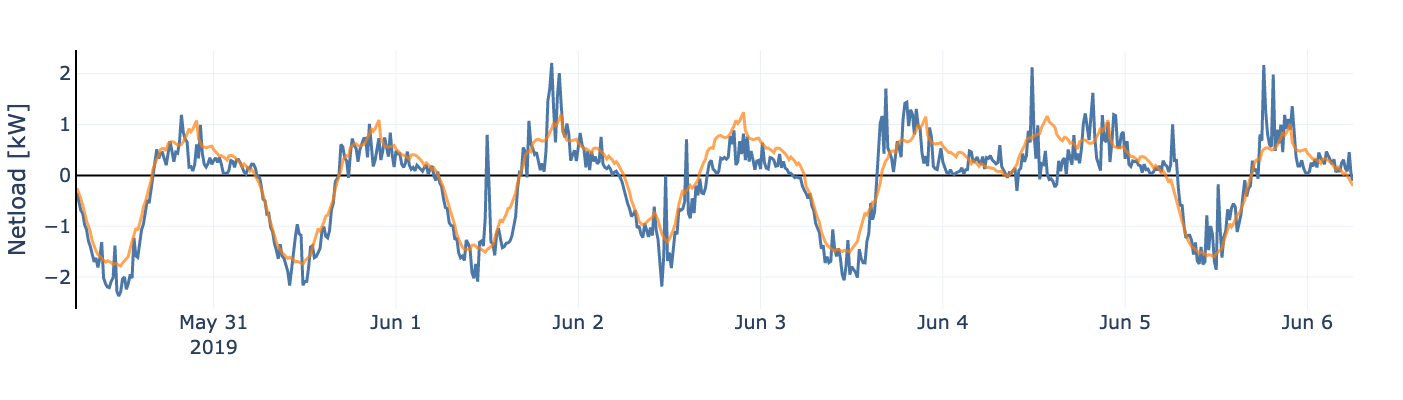

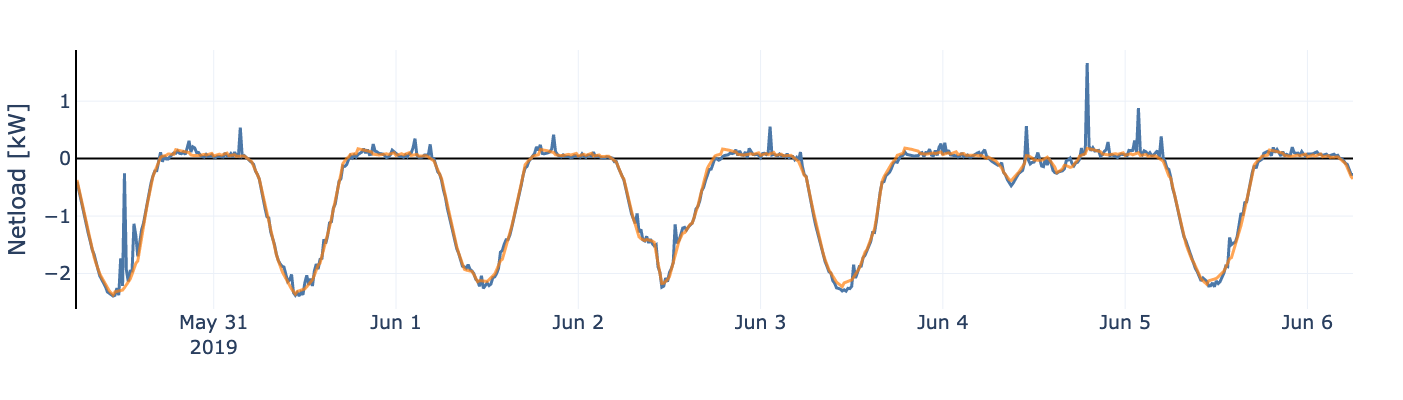

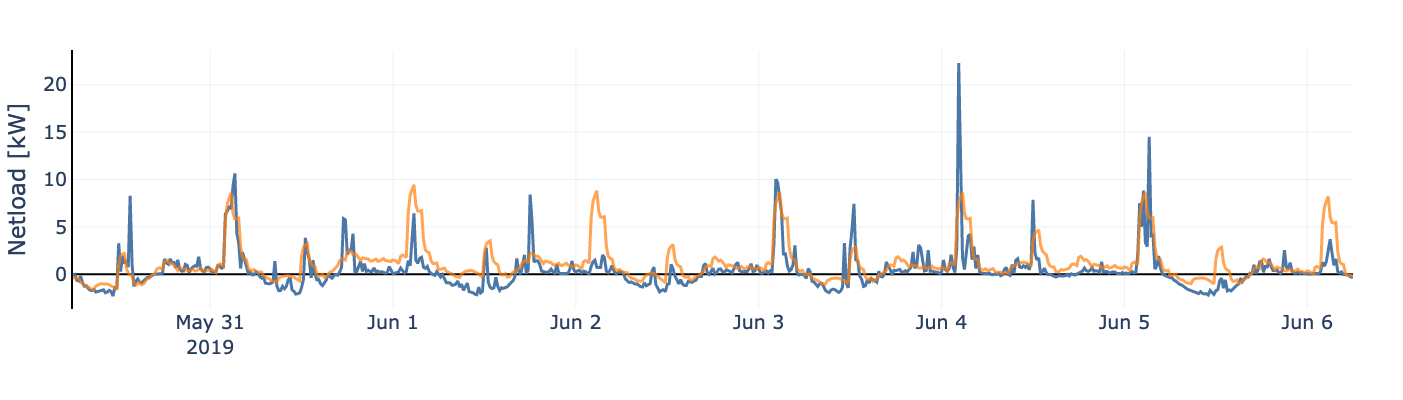

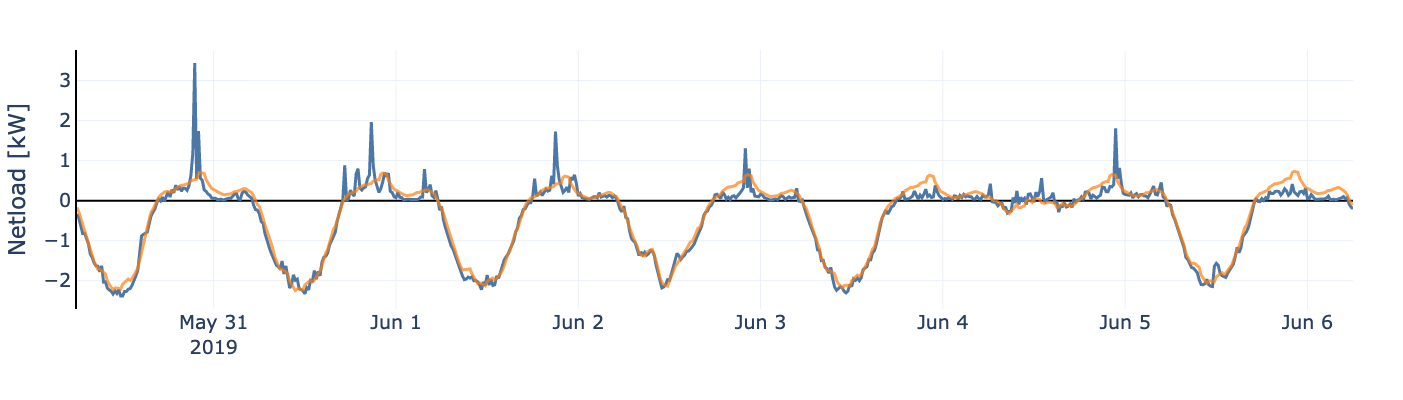

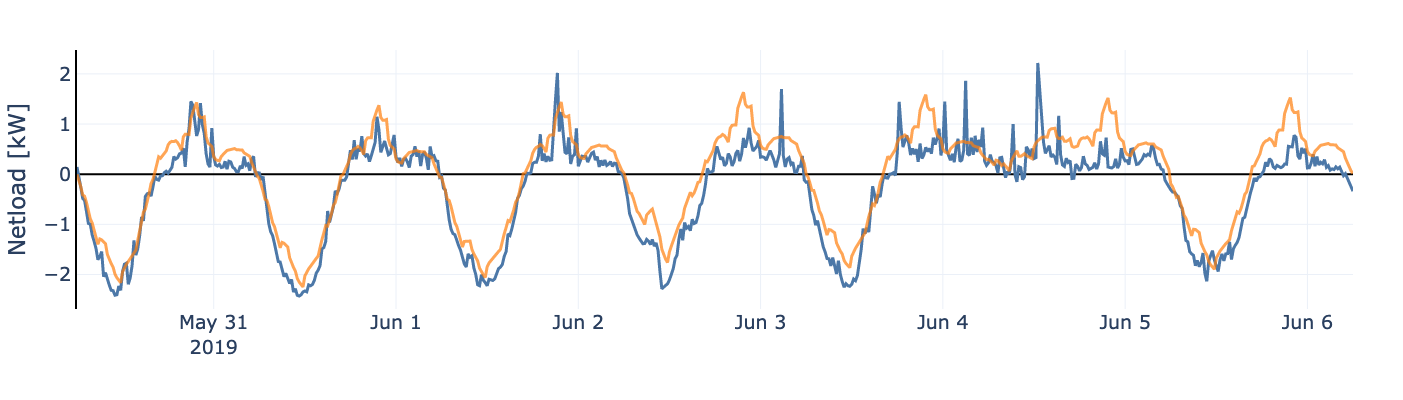

In [12]:
for house_id in house_ids[0:5]:
    graph = individuals.loc[start:end_complete_pred, [house_id]].copy()
    graph.columns = ["Ref"]

    fig = px.line(graph)
    fig.data[0].update(line_width=3)

    trace = px.line(house_forecast[house_id].loc[start:end_complete_pred]).data[0]
    fig.add_trace(trace)
    fig.data[-1].update(line_width=3, line_color="rgba(255, 127, 14, 0.7)")

    fig.update_layout(
        layout,
        height=400,
        width=900,
        showlegend=False,
        xaxis_title="",
        yaxis_title="Netload [kW]",
        yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
        xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
        xaxis_tickangle=0)
    fig.show()
    fig.write_image(f"results/MPC_freq=2d_horizon=2d_{house_id}.svg")

# Optimization freq=2D for 2D (-15min) horizon

In [13]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "glpk"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_energy(m, b):
            return m.batteryenergy[m.last, b] >= batteries[b]["end_kwh"]

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )

        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
#--->?? #m.r6 = Constraint(m.batteries, rule=r_battery_end_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum(m.batteryin[i, b] for b in m.batteries)
                for i in m.horizon
            )

        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

## Optimization on forecast

In [14]:
sub_house_ids = list(house_forecast.keys())
netload = pd.concat([house_forecast[house_id] for house_id in sub_house_ids], axis=1)
netload.head()

2000989   2001197   2000914   2001123   2000964
2019-05-30 06:00:00 -0.252154 -0.371384 -0.367737 -0.173974 -0.003423
2019-05-30 06:15:00 -0.348554 -0.521826 -0.401558 -0.281862 -0.110006
2019-05-30 06:30:00 -0.457602 -0.680728 -0.414056 -0.442036 -0.248571
2019-05-30 06:45:00 -0.582662 -0.840714 -0.429318 -0.599192 -0.413351
2019-05-30 07:00:00 -0.755427 -0.997006 -0.840327 -0.718190 -0.439792

In [15]:
schedules_concat = []
energy_concat = []
communityimport_concat = []
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [ref_spec for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=False, only_return_schedules=False)

for opti_start in tqdm(pd.date_range(end_training + deltat, end_complete_pred, freq=freq), desc="Optimization #"):
    tmp_netload = netload.loc[opti_start:opti_start+horizon].copy()
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    for i, house_id in enumerate(sub_house_ids):
        spec[i]["init_kwh"] = schedule["batteryenergy"].iloc[-1][i]
    
    schedules_concat.append(schedule["schedules"].copy())
    energy_concat.append(schedule["batteryenergy"].copy())
    communityimport_concat.append(schedule["community_import"].copy())

schedules_concat = pd.concat(schedules_concat, axis=0)
energy_concat = pd.concat(energy_concat, axis=0)
communityimport_concat = pd.concat(communityimport_concat, axis=0)

Optimization #:   0%|          | 0/4 [00:00<?, ?it/s]

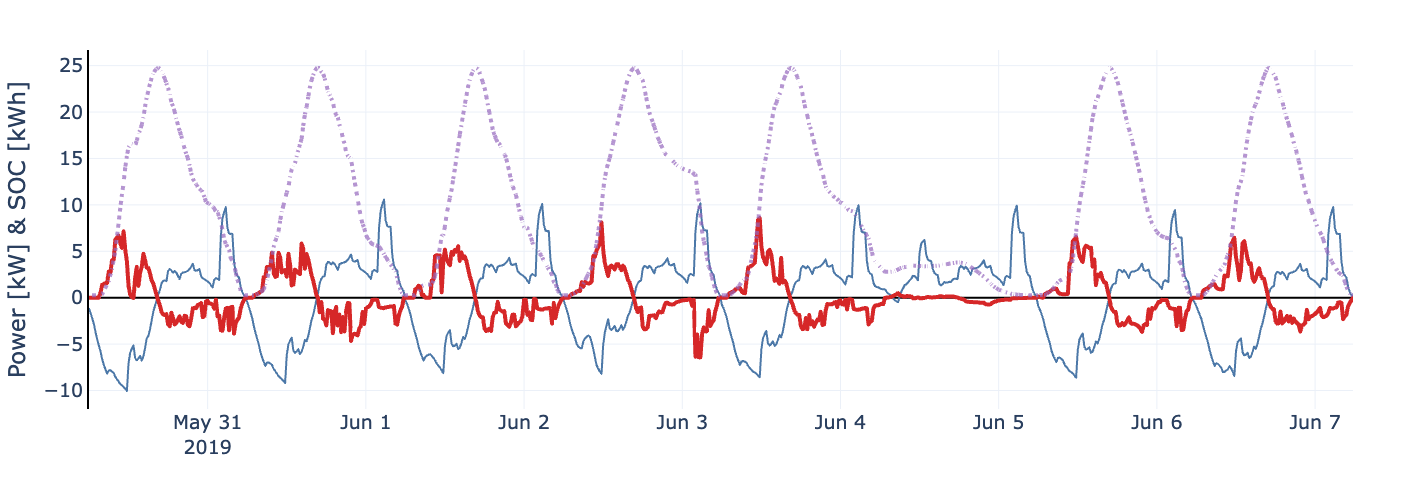

In [16]:
graph = netload.copy()
graph["netload_kw"] = graph[sub_house_ids].sum(axis=1)
graph.drop(sub_house_ids, axis=1, inplace=True)

graph["storage"] = schedules_concat.sum(axis=1)
graph["soc"] = energy_concat.sum(axis=1)


fig = px.line(graph, y=["netload_kw", "storage", "soc"])

fig.data[1].update(line_width=4, 
                   line_color="rgba(214, 39, 40, 1.0)")
fig.data[2].update(line_width=4, 
                   line_dash="dot", line_color="rgba(148, 103, 189, 0.7)")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SOC [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/forecast_2d.svg")

## Optimization on historical

In [17]:
perfect_schedules_concat = []
perfect_energy_concat = []
perfect_communityimport_concat = []

battery_size = 5
spec = [ref_spec for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=False, only_return_schedules=False)

for opti_start in tqdm(pd.date_range(end_training + deltat, end_complete_pred, freq=freq), desc="Optimization #"):
    tmp_netload = individuals.loc[opti_start:opti_start+horizon, sub_house_ids].copy()
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    for i, house_id in enumerate(sub_house_ids):
        spec[i]["init_kwh"] = schedule["batteryenergy"].iloc[-1][i]
    
    perfect_schedules_concat.append(schedule["schedules"].copy())
    perfect_energy_concat.append(schedule["batteryenergy"].copy())
    perfect_communityimport_concat.append(schedule["community_import"].copy())

perfect_schedules_concat = pd.concat(perfect_schedules_concat, axis=0)
perfect_energy_concat = pd.concat(perfect_energy_concat, axis=0)
perfect_communityimport_concat = pd.concat(perfect_communityimport_concat, axis=0)

Optimization #:   0%|          | 0/4 [00:00<?, ?it/s]

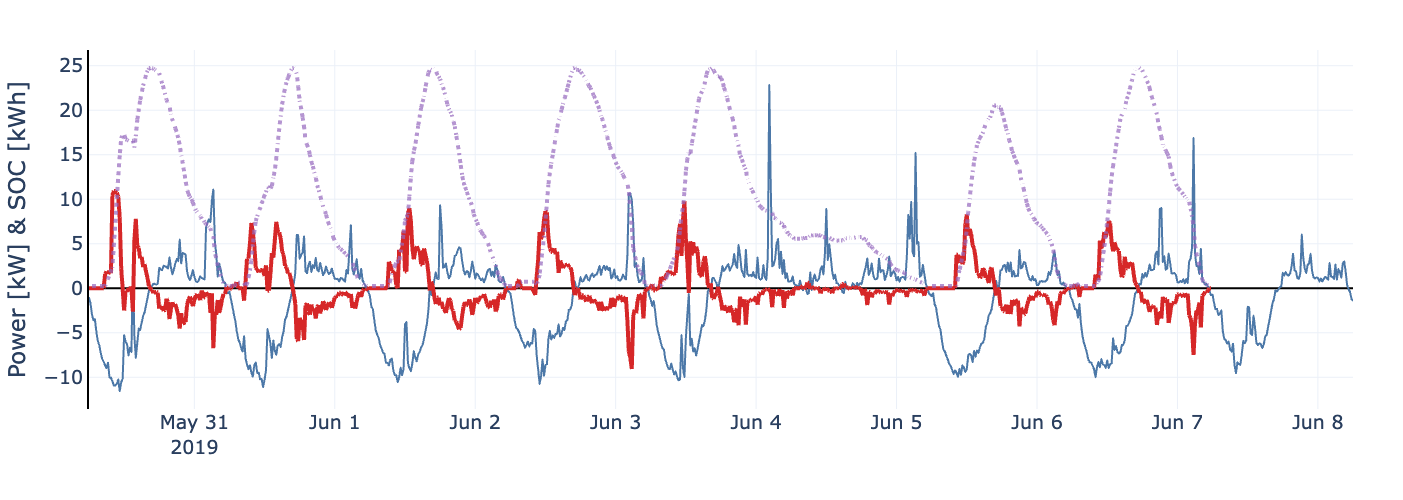

In [18]:
graph = individuals.loc[end_training + deltat:].copy()
graph["netload_kw"] = graph[sub_house_ids].sum(axis=1)
graph.drop(sub_house_ids, axis=1, inplace=True)

graph["storage"] = perfect_schedules_concat.sum(axis=1)
graph["soc"] = perfect_energy_concat.sum(axis=1)


fig = px.line(graph, y=["netload_kw", "storage", "soc"])

fig.data[1].update(line_width=4, 
                   line_color="rgba(214, 39, 40, 1.0)")
fig.data[2].update(line_width=4, 
                   line_dash="dot", line_color="rgba(148, 103, 189, 0.7)")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SOC [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/perfect_2d.svg")

In [60]:
def community_import_graph():
    graph = perfect_communityimport_concat.loc[:end_complete_pred].copy()
    graph.columns = ["check_perfect"]

    graph["Total"] = _individuals.loc[graph.index[0]:graph.index[-1], sub_house_ids].sum(axis=1)
    graph["pv_production_kw"] = pv_size * len(sub_house_ids) * _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
    print(f"Check PV size = {pv_size} kWp")

    graph["PV_only"] = (graph["Total"] - graph["pv_production_kw"]).clip(lower=0)
    graph["Perfect"] = (graph["Total"] - graph["pv_production_kw"] + perfect_schedules_concat.sum(axis=1)).clip(lower=0)
    graph["Forecast_2d"] = (graph["Total"] - graph["pv_production_kw"] + schedules_concat.sum(axis=1)).clip(lower=0)
    if 'schedules_concat_3h' in globals():
        graph["Forecast_3h"] = (graph["Total"] - graph["pv_production_kw"] + schedules_concat_3h.sum(axis=1)).clip(lower=0)
    return graph

Check PV size = 3 kWp


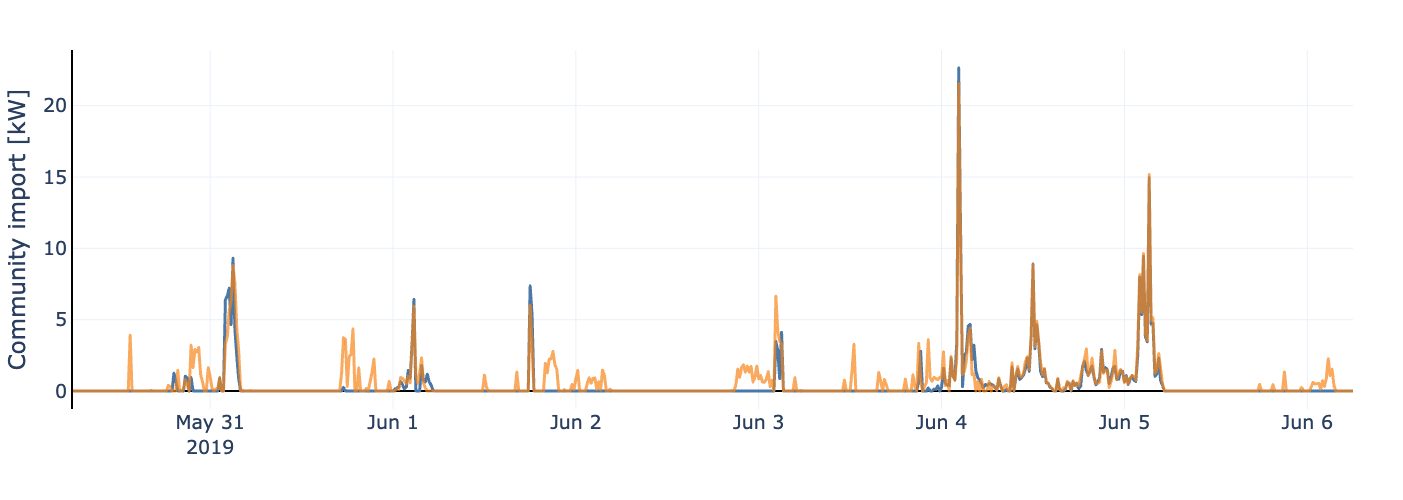

In [61]:
graph = community_import_graph()
fig = px.line(graph.loc[:end_complete_pred], y=["Perfect", "Forecast_2d"])

fig.data[0].update(line_width=3)
fig.data[1].update(line_width=3, opacity=0.7)
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Community import [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

Check PV size = 3 kWp


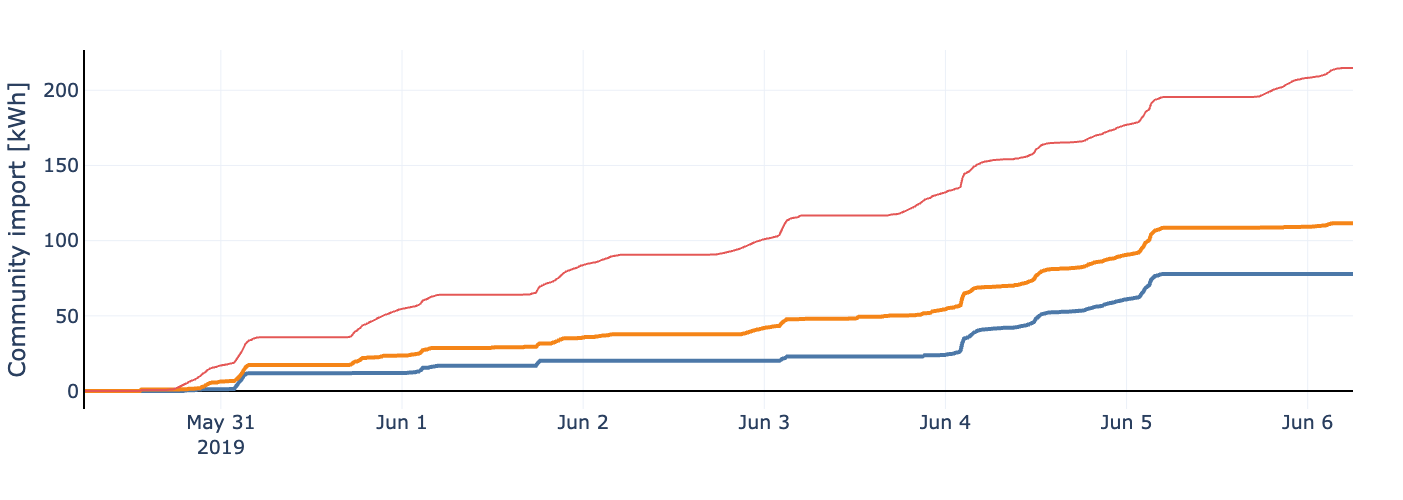

                     check_perfect       Total  pv_production_kw     PV_only  \
Index                                                                          
2019-06-06 06:00:00       77.85169  376.152018        556.996669  214.831661   

                      Perfect  Forecast_2d  Forecast_3h  
Index                                                    
2019-06-06 06:00:00  77.85169    111.63874    91.052435  


In [62]:
graph = community_import_graph()
graph = graph.cumsum(axis=0) / 4

fig = px.line(graph.loc[:end_complete_pred], y=["Perfect", "Forecast_2d", "PV_only"])

fig.data[0].update(line_width=4)
fig.data[1].update(line_width=4)
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Community import [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
print(graph.tail(1))

# MPC freq=$X$ for 2D (-15min) horizon

$X = 3h$

## Forecast at freq=$X$

In [37]:
start_training = start - training + timedelta(days=1)
end_training = start - deltat

horizon = timedelta(days=2) - deltat
end_complete_pred = start + timedelta(days=7)
freq_3h = f"180T"
freq_3h_delta = timedelta(hours=3) - deltat

In [27]:
house_forecast_3h = {}
best_parameters = {
    "2000989": {
                 "NB_LAG": 10,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
    "2001197": {
                 "NB_LAG": 4,
                 "PRIOR_GHI": 10,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
    "2000914": {
                 "NB_LAG": 5,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
    "2001123": {
                 "NB_LAG": 13,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
    "2000964": {
                 "NB_LAG": 4,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"
    },
}

for house_id in tqdm(house_ids[0:5], desc="House #"):
    graph = individuals[[house_id]].copy()
    graph["pv_1kw"] = df.loc[graph.index[0]:graph.index[-1], "pv_1kw"]

    graph["_datetime"] = graph.index
    for hour in range(0, 24):
        graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    graph.drop(columns="_datetime", inplace=True)

    results = model_3(graph, start_training, end_training, horizon,
                deltat, end_complete_pred, freq_3h, house_id, best_parameters[house_id])

    house_forecast_3h[house_id] = [res.copy() for res in results]

House #:   0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
# Make remove house_id to form netload_3h = []
house_forecast_3h_list = []

for i in range(0, len(house_forecast_3h[house_ids[0]])):
    tmp_3h = pd.concat([house_forecast_3h[house_id][i] for house_id in house_ids[0:5]], axis=1)
    house_forecast_3h_list.append(tmp_3h)

## Optimize at freq=$X$

In [38]:
schedules_concat_3h = []
energy_concat_3h = []
communityimport_concat_3h = []
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [ref_spec for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=False, only_return_schedules=False)

for jndex, opti_start in tqdm(enumerate(pd.date_range(end_training + deltat, end_complete_pred, freq=freq_3h)), 
                       desc="Optimization #", total=len(house_forecast_3h_list)):
    tmp_netload = house_forecast_3h_list[jndex].loc[opti_start:opti_start+horizon].copy()
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    for i, house_id in enumerate(sub_house_ids):
        spec[i]["init_kwh"] = schedule["batteryenergy"].at[opti_start+freq_3h_delta, i]
    
    schedules_concat_3h.append(schedule["schedules"].loc[opti_start:opti_start+freq_3h_delta].copy())
    energy_concat_3h.append(schedule["batteryenergy"].loc[opti_start:opti_start+freq_3h_delta].copy())
    communityimport_concat_3h.append(schedule["community_import"].loc[opti_start:opti_start+freq_3h_delta].copy())

schedules_concat_3h = pd.concat(schedules_concat_3h, axis=0)
energy_concat_3h = pd.concat(energy_concat_3h, axis=0)
communityimport_concat_3h = pd.concat(communityimport_concat_3h, axis=0)

Optimization #:   0%|          | 0/57 [00:00<?, ?it/s]

In [39]:
netload_3h = pd.DataFrame()
for all_house_forecast_3h, start_3h in zip(house_forecast_3h_list, pd.date_range(end_training + deltat, end_complete_pred, freq=freq_3h)):
    netload_3h = pd.concat([netload_3h, all_house_forecast_3h.loc[start_3h:start_3h+freq_3h_delta]], axis=0)

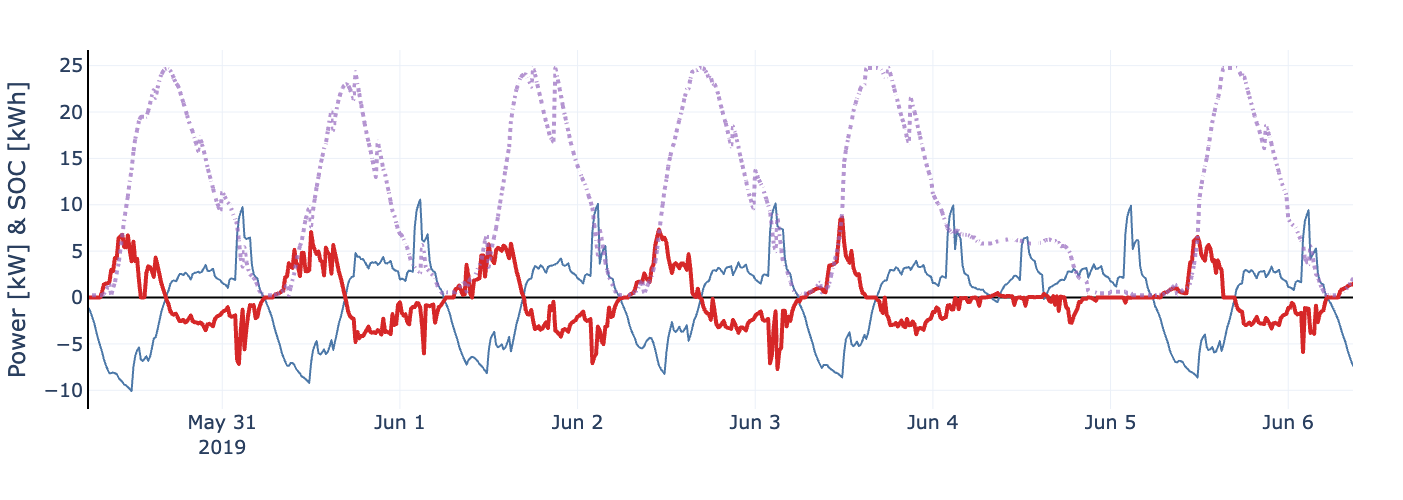

In [40]:
graph = netload_3h.copy()
graph["netload_kw"] = graph[sub_house_ids].sum(axis=1)
graph.drop(sub_house_ids, axis=1, inplace=True)

graph["storage"] = schedules_concat_3h.sum(axis=1)
graph["soc"] = energy_concat_3h.sum(axis=1)


fig = px.line(graph, y=["netload_kw", "storage", "soc"])

fig.data[1].update(line_width=4, 
                   line_color="rgba(214, 39, 40, 1.0)")
fig.data[2].update(line_width=4, 
                   line_dash="dot", line_color="rgba(148, 103, 189, 0.7)")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SOC [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/forecast_2d.svg")

Check PV size = 3 kWp


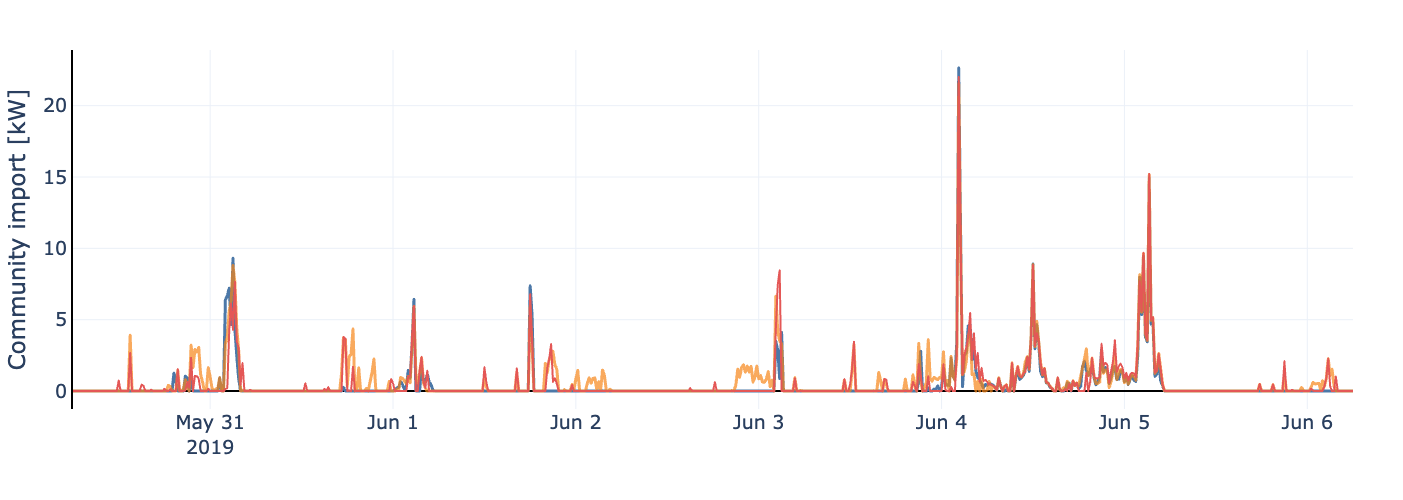

In [64]:
graph = community_import_graph()
fig = px.line(graph.loc[:end_complete_pred], y=["Perfect", "Forecast_2d", "Forecast_3h"])

fig.data[0].update(line_width=3)
fig.data[1].update(line_width=3, opacity=0.7)
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Community import [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/community_import_2d.svg")

Check PV size = 3 kWp


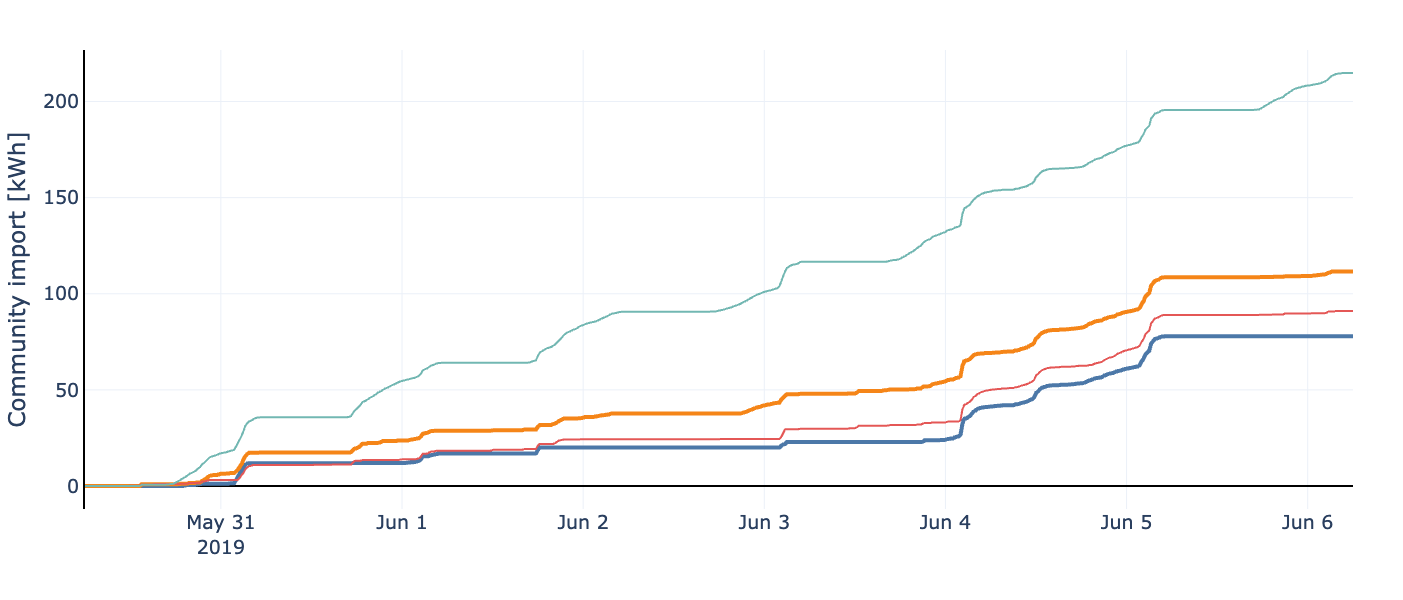

                     check_perfect       Total  pv_production_kw     PV_only  \
Index                                                                          
2019-06-06 06:00:00       77.85169  376.152018        556.996669  214.831661   

                      Perfect  Forecast_2d  Forecast_3h  
Index                                                    
2019-06-06 06:00:00  77.85169    111.63874    91.052435  


In [79]:
graph = community_import_graph()
graph = graph.cumsum(axis=0) / 4

fig = px.line(graph.loc[:end_complete_pred], y=["Perfect", "Forecast_2d", "Forecast_3h", "PV_only"])

fig.data[0].update(line_width=4)
fig.data[1].update(line_width=4)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Community import [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/cumsum_community_import_2d.svg")
print(graph.tail(1))

In [75]:
graph.tail(1) * 0.1740

check_perfect      Total  pv_production_kw    PV_only  \
Index                                                                        
2019-06-06 06:00:00      13.546194  65.450451          96.91742  37.380709   

                       Perfect  Forecast_2d  Forecast_3h  
Index                                                     
2019-06-06 06:00:00  13.546194    19.425141    15.843124

## Compare in €

In [66]:
def community_bill(df, member_ids, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            #- df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            #(df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

In [67]:
graph = schedules_concat.copy()
graph.columns = sub_house_ids
for col in graph.columns:
    graph[col] += individuals.loc[graph.index[0]:graph.index[-1], col]

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Forecast cost = {np.round(forecast_cost, 2)} €")

Forecast cost = 24.78 €


In [68]:
graph = schedules_concat_3h.copy()
graph.columns = sub_house_ids
for col in graph.columns:
    graph[col] += individuals.loc[graph.index[0]:graph.index[-1], col]

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Forecast cost = {np.round(forecast_cost, 2)} €")

Forecast cost = 18.98 €


In [69]:
graph = perfect_schedules_concat.copy()
graph.columns = sub_house_ids
for col in graph.columns:
    graph[col] += individuals.loc[graph.index[0]:graph.index[-1], col]

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Optimization cost = {np.round(forecast_cost, 2)} €")

Optimization cost = 16.75 €


Note that running optimization at midnight up the cost to 20.96 € in the perfect case. This is due to not charging the battery completely during the second day (not enough to discharge).

In [73]:
graph = individuals.loc[graph.index[0]:graph.index[-1], sub_house_ids].copy()

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"PV only cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="1D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical 1d cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="2D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical 2d cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="365D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical cost = {np.round(forecast_cost, 2)} €")

PV only cost = 43.55 €
Theoretical 1d cost = 11.47 €
Theoretical 2d cost = 6.6 €
Theoretical cost = 2.68 €
